In [1]:
# Defaults
REGION = 'fortportal'
POP = 'grid_population'
UTM = 32636
CLUSTER_COUNT = 10

In [2]:
# Parameters
REGION = "entebbe"
UTM = 32636
POP = "grid_population"
PIPELINE = "cluster"


In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn import cluster
from pathlib import Path
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation


warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [4]:
CWD = Path('.')
DATA = Path('data')

INTER  = DATA/'inter'
INPUT  = DATA/'input'
OUTPUT = DATA/'output'

In [5]:
!ls {OUTPUT} | grep {REGION}

entebbe_grids_output_4326.geojson


In [6]:
grids_gdf = gpd.read_file(f'{OUTPUT}/{REGION}_grids_output_{4326}.geojson').to_crs(epsg=UTM)

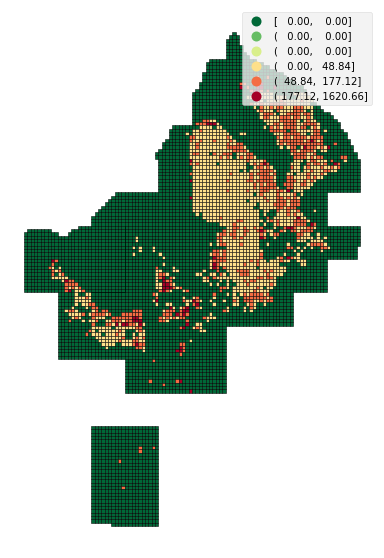

In [7]:
grids_gdf.plot(figsize=(10,10), cmap='RdYlGn_r', edgecolor='black', alpha=1, column=POP, scheme='percentiles', legend=True)
plt.gca().set_axis_off()

In [8]:
grids_gdf.head()

,idx,grid_building_area,grid_building_count,tile_idx,tile_population,tile_width,tile_height,tile_building_count,tile_building_area,grid_population,geometry
0,0,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.221 11606.155, 439817.962 116..."
1,1,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.220 11514.046, 439817.960 115..."
2,2,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.218 11421.937, 439817.959 114..."
3,3,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.217 11329.829, 439817.957 113..."
4,4,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.215 11237.720, 439817.956 112..."


In [9]:
def make_copy(gdf): return gdf.copy()

In [10]:
def moran_cluster(gdf):
    w = weights.Queen.from_dataframe(gdf, idVariable='idx')
    gdf = gdf[~gdf.idx.isin(w.islands)]
    w = weights.Queen.from_dataframe(gdf, idVariable='idx')
    w.tranform = 'R'
    gdf[f'w_{POP}'] = weights.lag_spatial(w, gdf[POP])
    # MI = esda.Moran(gdf[f'w_{POP}'], w)
    LISA = esda.Moran_Local(gdf[f'w_{POP}'], w) 
    gdf['significance'] = LISA.p_sim < 0.05
    gdf['_quad'] = LISA.q
    gdf['quad'] = gdf['_quad'].replace({
        1: 'HH',
        2: 'LH',
        3: 'LL',
        4: 'HL'
    })
    
    moran_dissolved_gdf = (gdf[['geometry', 'grid_population', 'grid_building_count', 'grid_building_area', 'quad']]
            .dissolve(by='quad', aggfunc='mean')
            .reset_index())
    
    return gdf, LISA, moran_dissolved_gdf

# Cluster regions based on Moran Index

In [11]:
moran_gdf, LISA, moran_dissolved_gdf = grids_gdf.pipe(make_copy).pipe(moran_cluster)

In [12]:
moran_gdf.head()

,idx,grid_building_area,grid_building_count,tile_idx,tile_population,tile_width,tile_height,tile_building_count,tile_building_area,grid_population,geometry,w_grid_population,significance,_quad,quad
0,0,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.221 11606.155, 439817.962 116...",0.0,True,3,LL
1,1,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.220 11514.046, 439817.960 115...",0.0,True,3,LL
2,2,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.218 11421.937, 439817.959 114...",0.0,True,3,LL
3,3,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.217 11329.829, 439817.957 113...",0.0,True,3,LL
4,4,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.215 11237.720, 439817.956 112...",0.0,True,3,LL


In [13]:
moran_gdf['quad'].value_counts()

LL    4027
HH    2050
LH     309
HL     147
Name: quad, dtype: int64

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

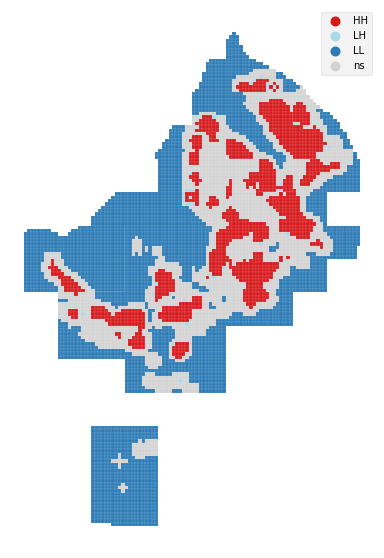

In [14]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
lisa_cluster(LISA, moran_gdf, ax=ax)

(<Figure size 1440x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

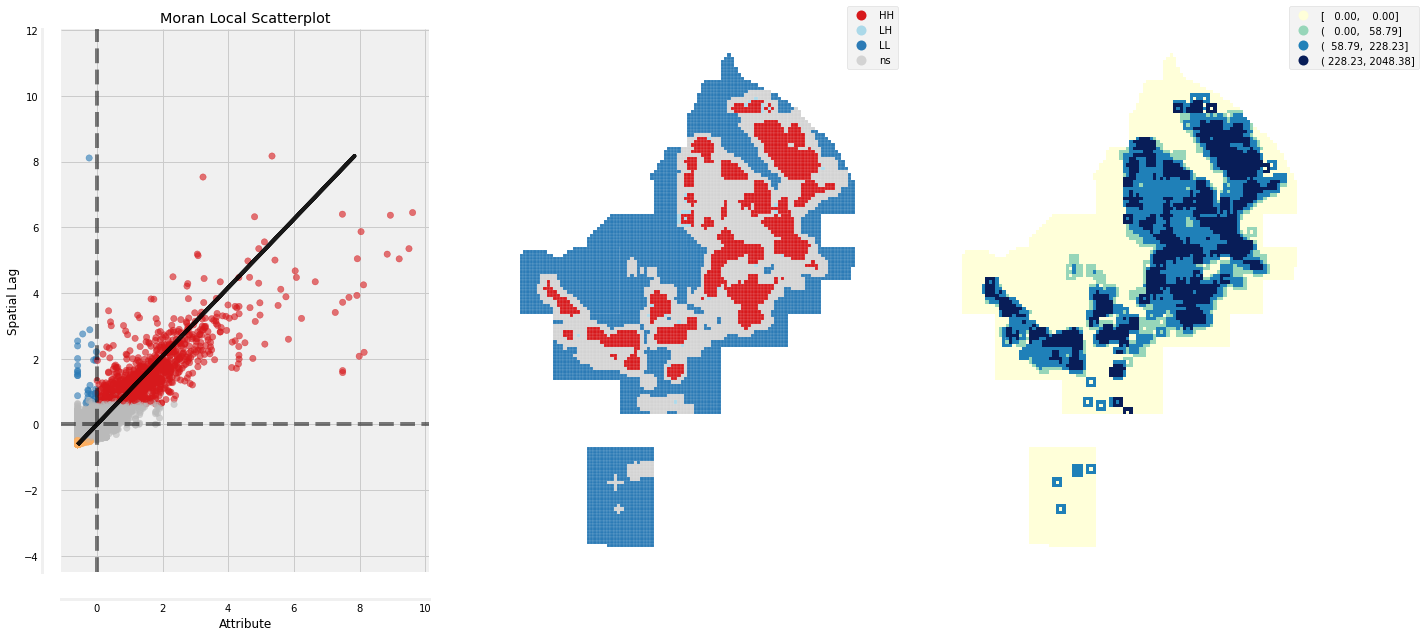

In [15]:
plot_local_autocorrelation(LISA, moran_gdf, f'w_{POP}', figsize=(20, 10))

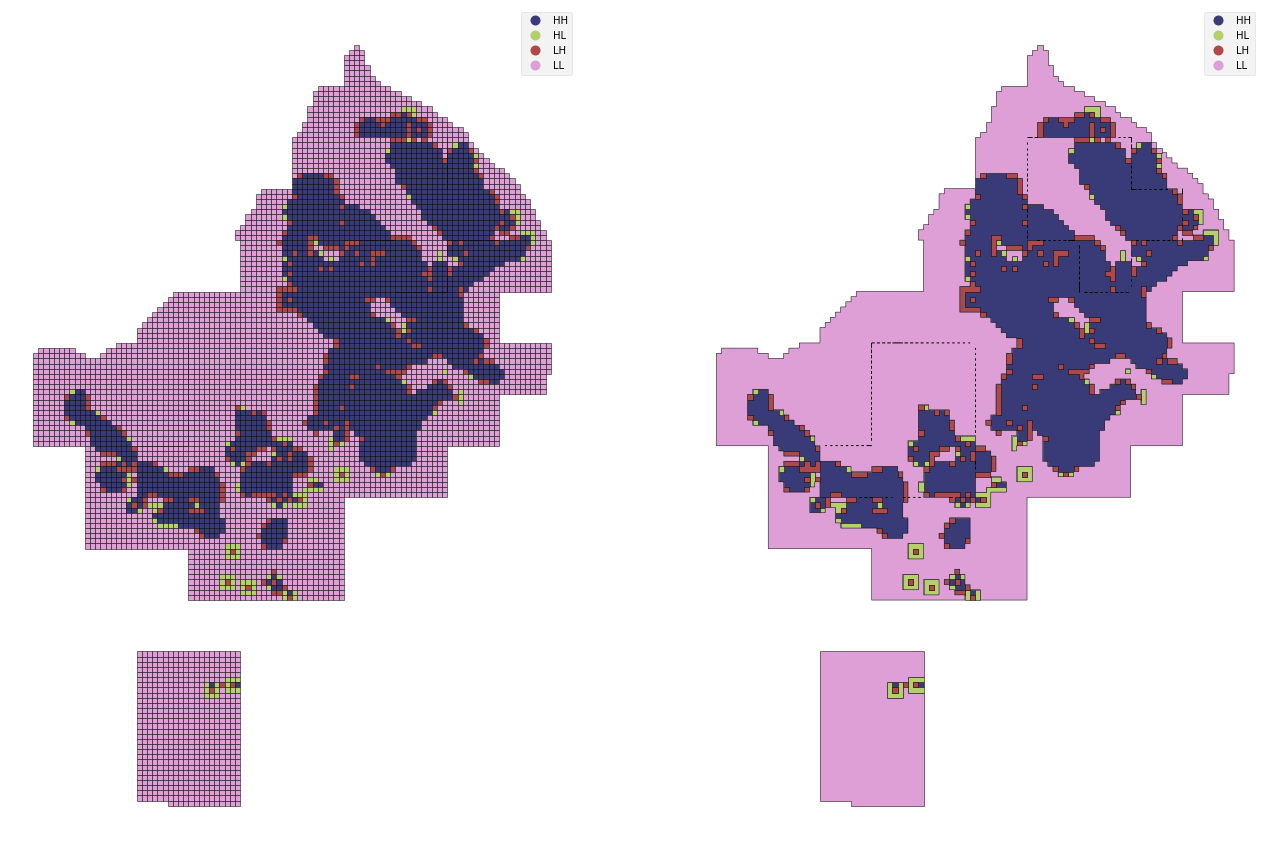

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 20))

moran_gdf.plot(ax=ax1, cmap='tab20b', edgecolor='black', categorical=True, column='quad', figsize=(20, 20), legend=True)
moran_dissolved_gdf.plot(ax=ax2, cmap='tab20b', edgecolor='black', categorical=True, column='quad', figsize=(20, 20), legend=True)
ax1.set_axis_off()
ax2.set_axis_off()

# Cluster regions based on K-Means

In [17]:
def kmeans_cluster(gdf, k=CLUSTER_COUNT):
    k_score = cluster.KMeans(n_clusters=k)
    gdf['k_score'] = k_score.fit(gdf[['grid_population']]).labels_
    kmeans_dissolved_gdf = (gdf[['geometry', 'grid_population', 'grid_building_count', 'grid_building_area', 'k_score']]
                    .dissolve(by='k_score', aggfunc='mean')
                    .reset_index())
    
    return gdf, kmeans_dissolved_gdf

In [18]:
kmeans_gdf, kmeans_dissolved_gdf = grids_gdf.pipe(make_copy).pipe(kmeans_cluster)

In [19]:
kmeans_gdf.head()

,idx,grid_building_area,grid_building_count,tile_idx,tile_population,tile_width,tile_height,tile_building_count,tile_building_area,grid_population,geometry,k_score
0,0,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.221 11606.155, 439817.962 116...",0
1,1,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.220 11514.046, 439817.960 115...",0
2,2,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.218 11421.937, 439817.959 114...",0
3,3,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.217 11329.829, 439817.957 113...",0
4,4,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.215 11237.720, 439817.956 112...",0


In [20]:
kmeans_dissolved_gdf

,k_score,geometry,grid_population,grid_building_count,grid_building_area
0,0,"MULTIPOLYGON (((439725.124 1934.396, 439725.12...",0.195736,0.043696,4.327445
1,1,"MULTIPOLYGON (((437406.821 276.327, 437406.821...",101.151097,7.633333,948.321501
2,2,"MULTIPOLYGON (((438426.912 3039.708, 438519.64...",410.361882,4.909091,1026.071135
3,3,"POLYGON ((438705.135 7276.929, 438797.864 7276...",1620.661621,2.000000,122.240987
4,4,"MULTIPOLYGON (((436757.664 3316.044, 436757.66...",39.476868,6.950000,862.955218
5,5,"MULTIPOLYGON (((437685.044 368.436, 437777.785...",156.000647,7.805195,1085.604798
6,6,"MULTIPOLYGON (((437963.241 4881.940, 438055.97...",853.180009,4.000000,3748.005157
7,7,"MULTIPOLYGON (((438705.097 1934.399, 438797.82...",240.964462,9.400000,1354.643863
8,8,"MULTIPOLYGON (((440003.363 5250.422, 440003.36...",19.474413,3.990698,482.450887
9,9,"MULTIPOLYGON (((436850.386 -736.874, 436943.11...",64.619333,7.312925,993.451994


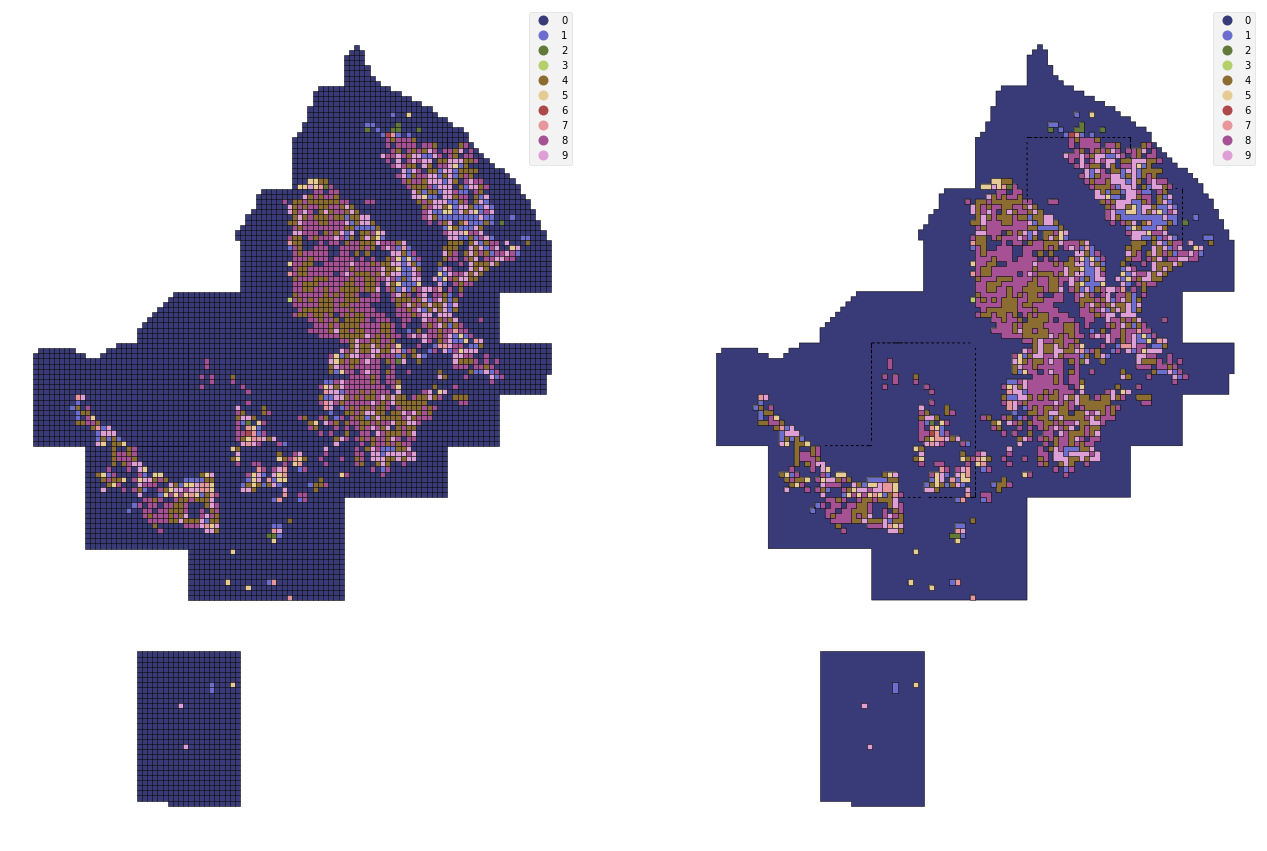

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 20))

kmeans_gdf.plot(ax=ax1, cmap='tab20b', edgecolor='black', column='k_score', categorical=True, figsize=(20, 20), legend=True)
kmeans_dissolved_gdf.plot(ax=ax2, cmap='tab20b', edgecolor='black', column='k_score', categorical=True, figsize=(20, 20), legend=True)
ax1.set_axis_off()
ax2.set_axis_off()

# Cluster regions based on spatial similarity

In [22]:
def agglomerative_cluster(gdf, k=CLUSTER_COUNT*2):
    w = weights.Queen.from_dataframe(gdf)
    a_score = cluster.AgglomerativeClustering(n_clusters=k, connectivity=w.sparse) 
    gdf['a_score'] = a_score.fit(gdf[['grid_population']]).labels_
    agglomerative_dissolved_gdf = (gdf[['geometry', 'grid_population', 'grid_building_count', 'grid_building_area', 'a_score']]
                                       .dissolve(by='a_score', aggfunc='mean')
                                       .reset_index())
    
    return gdf, agglomerative_dissolved_gdf

In [23]:
agglomerative_gdf, agglomerative_dissolved_gdf = agglomerative_cluster(grids_gdf)

In [24]:
agglomerative_gdf.head()

,idx,grid_building_area,grid_building_count,tile_idx,tile_population,tile_width,tile_height,tile_building_count,tile_building_area,grid_population,geometry,a_score
0,0,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.221 11606.155, 439817.962 116...",6
1,1,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.220 11514.046, 439817.960 115...",6
2,2,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.218 11421.937, 439817.959 114...",6
3,3,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.217 11329.829, 439817.957 113...",6
4,4,0.0,0,0,0.0,1,1,0,0.0,0.0,"POLYGON ((439725.215 11237.720, 439817.956 112...",6


In [25]:
agglomerative_dissolved_gdf

,a_score,geometry,grid_population,grid_building_count,grid_building_area
0,0,"MULTIPOLYGON (((440467.059 4237.178, 440467.05...",38.961039,6.705882,933.005623
1,1,"MULTIPOLYGON (((438148.701 3868.698, 438148.70...",121.028288,4.448276,538.230083
2,2,"MULTIPOLYGON (((437406.832 3776.590, 437406.83...",99.669307,4.283333,372.898552
3,3,"POLYGON ((440467.039 8382.267, 440467.037 8290...",64.716845,6.105263,781.618576
4,4,"MULTIPOLYGON (((438055.973 4697.713, 438055.97...",237.045846,8.777778,1046.758559
5,5,"MULTIPOLYGON (((441950.767 8382.249, 441950.76...",68.427734,7.654450,813.087542
6,6,"MULTIPOLYGON (((439725.124 1934.396, 439725.12...",3.546955,0.275054,29.343248
7,7,"POLYGON ((438705.135 7276.929, 438797.864 7276...",1620.661621,2.000000,122.240987
8,8,"POLYGON ((438519.642 3039.708, 438519.641 2947...",390.799158,4.666667,633.649981
9,9,"MULTIPOLYGON (((441208.893 7461.134, 441301.62...",94.567804,10.750000,941.864723


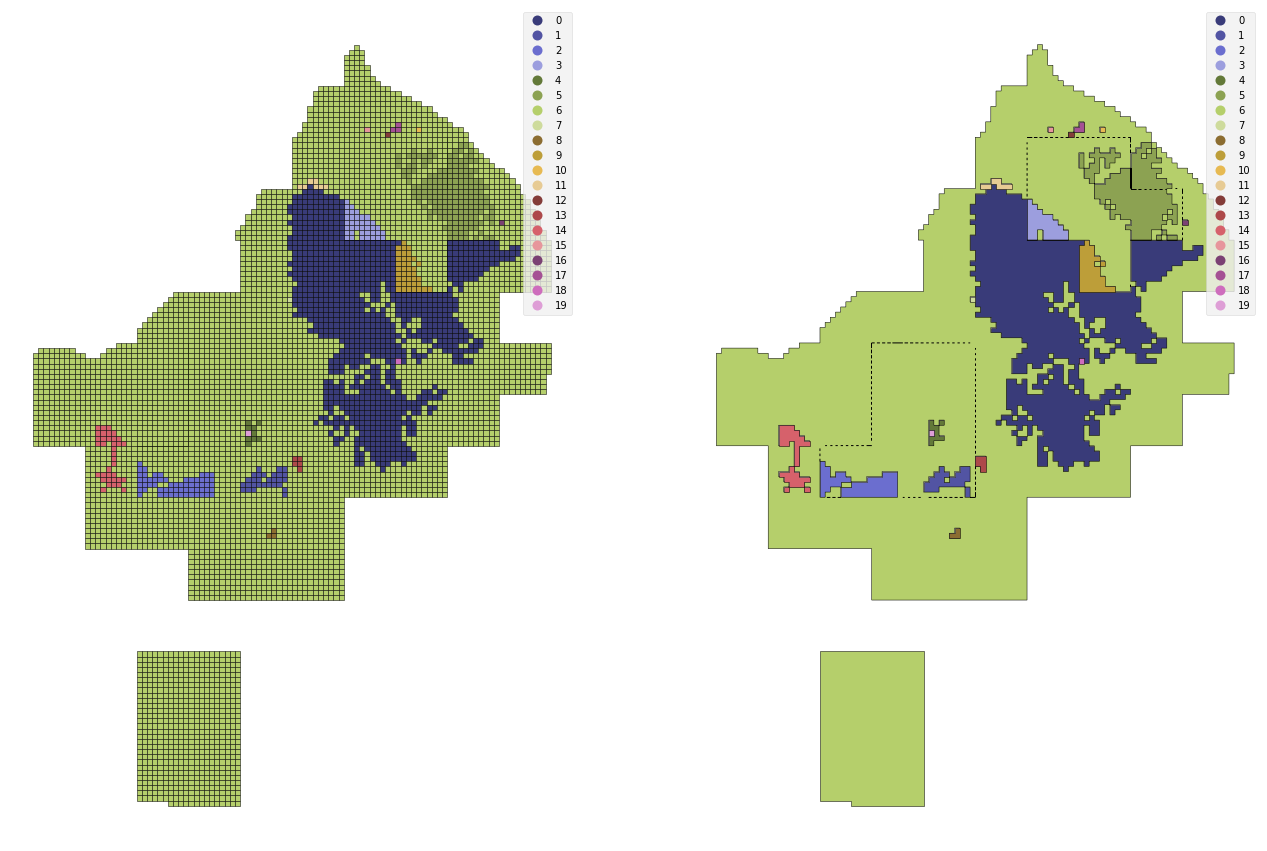

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 20))

agglomerative_gdf.plot(ax=ax1, cmap='tab20b', edgecolor='black', column='a_score', categorical=True, figsize=(20, 20), legend=True)
agglomerative_dissolved_gdf.plot(ax=ax2, cmap='tab20b', edgecolor='black', column='a_score', categorical=True, figsize=(20, 20), legend=True)

ax1.set_axis_off()
ax2.set_axis_off()

### Save the analysed results

In [27]:
moran_dissolved_gdf.to_crs(epsg=4326).to_file(f'{OUTPUT/REGION}_moran.geojson', driver='GeoJSON')
kmeans_dissolved_gdf.to_crs(epsg=4326).to_file(f'{OUTPUT/REGION}_kmeans.geojson', driver='GeoJSON')
agglomerative_dissolved_gdf.to_crs(epsg=4326).to_file(f'{OUTPUT/REGION}_agglomerative.geojson', driver='GeoJSON')